In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [4]:
from torch.utils.data import random_split

def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [5]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

tensor(9)
tensor(0)


In [6]:
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.001 #0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
use_decoder_sigmoid = True

In [7]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [8]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    prior_std=PRIOR_STD,
    result_folder="semisupervised_results/100_epochs_adam_results"
)

Epoch [1/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/100 — Recon: 0.0609, Disc_Cat: 0.3663, Gen_Cat: 5.0771, Disc_Style: 0.3417, Gen_Style: 5.4662, SemiSup: 3.7592
Validation Accuracy: 35.26%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [2/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/100 — Recon: 0.0388, Disc_Cat: 0.6897, Gen_Cat: 5.5884, Disc_Style: 0.5254, Gen_Style: 5.2608, SemiSup: 1.9409
Validation Accuracy: 63.97%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [3/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/100 — Recon: 0.0290, Disc_Cat: 0.8686, Gen_Cat: 4.1864, Disc_Style: 0.7717, Gen_Style: 3.9845, SemiSup: 1.8868
Validation Accuracy: 66.53%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [4/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/100 — Recon: 0.0237, Disc_Cat: 1.0532, Gen_Cat: 3.9667, Disc_Style: 0.9341, Gen_Style: 2.2338, SemiSup: 1.0771
Validation Accuracy: 89.10%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [5/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/100 — Recon: 0.0206, Disc_Cat: 1.2045, Gen_Cat: 2.6495, Disc_Style: 0.8671, Gen_Style: 1.6885, SemiSup: 0.4570
Validation Accuracy: 90.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [6/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/100 — Recon: 0.0195, Disc_Cat: 1.2204, Gen_Cat: 2.3635, Disc_Style: 0.9750, Gen_Style: 1.4802, SemiSup: 0.3995
Validation Accuracy: 92.09%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [7/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/100 — Recon: 0.0189, Disc_Cat: 1.2296, Gen_Cat: 2.1795, Disc_Style: 1.0082, Gen_Style: 1.4119, SemiSup: 0.3494
Validation Accuracy: 92.69%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [8/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/100 — Recon: 0.0188, Disc_Cat: 1.2388, Gen_Cat: 2.0152, Disc_Style: 1.1004, Gen_Style: 1.3047, SemiSup: 0.3109
Validation Accuracy: 93.13%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [9/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/100 — Recon: 0.0183, Disc_Cat: 1.2491, Gen_Cat: 1.8310, Disc_Style: 1.1211, Gen_Style: 1.2047, SemiSup: 0.2894
Validation Accuracy: 93.14%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [10/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/100 — Recon: 0.0180, Disc_Cat: 1.2533, Gen_Cat: 1.7211, Disc_Style: 1.1690, Gen_Style: 1.1182, SemiSup: 0.2686
Validation Accuracy: 93.89%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [11/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/100 — Recon: 0.0179, Disc_Cat: 1.2599, Gen_Cat: 1.6459, Disc_Style: 1.1807, Gen_Style: 1.0888, SemiSup: 0.2586
Validation Accuracy: 93.82%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [12/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/100 — Recon: 0.0178, Disc_Cat: 1.2672, Gen_Cat: 1.5677, Disc_Style: 1.2146, Gen_Style: 1.0339, SemiSup: 0.2444
Validation Accuracy: 94.18%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [13/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/100 — Recon: 0.0176, Disc_Cat: 1.2722, Gen_Cat: 1.4675, Disc_Style: 1.2509, Gen_Style: 0.9893, SemiSup: 0.2343
Validation Accuracy: 94.37%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [14/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/100 — Recon: 0.0174, Disc_Cat: 1.2749, Gen_Cat: 1.4090, Disc_Style: 1.2676, Gen_Style: 0.9439, SemiSup: 0.2221
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [15/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/100 — Recon: 0.0171, Disc_Cat: 1.2826, Gen_Cat: 1.3634, Disc_Style: 1.2656, Gen_Style: 0.9374, SemiSup: 0.2187
Validation Accuracy: 94.85%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [16/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/100 — Recon: 0.0172, Disc_Cat: 1.2849, Gen_Cat: 1.3082, Disc_Style: 1.2865, Gen_Style: 0.9106, SemiSup: 0.2089
Validation Accuracy: 95.04%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [17/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/100 — Recon: 0.0172, Disc_Cat: 1.2885, Gen_Cat: 1.2657, Disc_Style: 1.2961, Gen_Style: 0.8966, SemiSup: 0.2038
Validation Accuracy: 95.13%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [18/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/100 — Recon: 0.0168, Disc_Cat: 1.2929, Gen_Cat: 1.2168, Disc_Style: 1.3144, Gen_Style: 0.8650, SemiSup: 0.1948
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [19/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/100 — Recon: 0.0168, Disc_Cat: 1.2937, Gen_Cat: 1.2147, Disc_Style: 1.3157, Gen_Style: 0.8480, SemiSup: 0.1861
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [20/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/100 — Recon: 0.0167, Disc_Cat: 1.3009, Gen_Cat: 1.1508, Disc_Style: 1.3243, Gen_Style: 0.8321, SemiSup: 0.1918
Validation Accuracy: 95.18%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [21/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/100 — Recon: 0.0169, Disc_Cat: 1.3004, Gen_Cat: 1.1457, Disc_Style: 1.3336, Gen_Style: 0.8198, SemiSup: 0.1843
Validation Accuracy: 95.65%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [22/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/100 — Recon: 0.0164, Disc_Cat: 1.3049, Gen_Cat: 1.1065, Disc_Style: 1.3360, Gen_Style: 0.8092, SemiSup: 0.1842
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [23/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23/100 — Recon: 0.0167, Disc_Cat: 1.3052, Gen_Cat: 1.0997, Disc_Style: 1.3399, Gen_Style: 0.8105, SemiSup: 0.1781
Validation Accuracy: 95.54%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [24/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/100 — Recon: 0.0167, Disc_Cat: 1.3068, Gen_Cat: 1.0928, Disc_Style: 1.3488, Gen_Style: 0.8013, SemiSup: 0.1756
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [25/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/100 — Recon: 0.0161, Disc_Cat: 1.3088, Gen_Cat: 1.0747, Disc_Style: 1.3607, Gen_Style: 0.7664, SemiSup: 0.1756
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [26/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 26/100 — Recon: 0.0162, Disc_Cat: 1.3116, Gen_Cat: 1.0435, Disc_Style: 1.3623, Gen_Style: 0.7610, SemiSup: 0.1690
Validation Accuracy: 95.70%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [27/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 27/100 — Recon: 0.0162, Disc_Cat: 1.3125, Gen_Cat: 1.0516, Disc_Style: 1.3638, Gen_Style: 0.7644, SemiSup: 0.1719
Validation Accuracy: 95.76%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [28/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 28/100 — Recon: 0.0164, Disc_Cat: 1.3119, Gen_Cat: 1.0700, Disc_Style: 1.3673, Gen_Style: 0.7572, SemiSup: 0.1738
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [29/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 29/100 — Recon: 0.0163, Disc_Cat: 1.3147, Gen_Cat: 1.1181, Disc_Style: 1.3678, Gen_Style: 0.7524, SemiSup: 0.1794
Validation Accuracy: 95.68%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [30/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 30/100 — Recon: 0.0161, Disc_Cat: 1.3151, Gen_Cat: 1.1664, Disc_Style: 1.3720, Gen_Style: 0.7375, SemiSup: 0.1757
Validation Accuracy: 96.02%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [31/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 31/100 — Recon: 0.0163, Disc_Cat: 1.3160, Gen_Cat: 1.2089, Disc_Style: 1.3725, Gen_Style: 0.7459, SemiSup: 0.1835
Validation Accuracy: 95.97%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [32/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 32/100 — Recon: 0.0158, Disc_Cat: 1.3182, Gen_Cat: 1.2364, Disc_Style: 1.3755, Gen_Style: 0.7393, SemiSup: 0.1812
Validation Accuracy: 95.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [33/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 33/100 — Recon: 0.0160, Disc_Cat: 1.3167, Gen_Cat: 1.2799, Disc_Style: 1.3758, Gen_Style: 0.7383, SemiSup: 0.1782
Validation Accuracy: 95.97%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [34/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 34/100 — Recon: 0.0158, Disc_Cat: 1.3199, Gen_Cat: 1.2791, Disc_Style: 1.3788, Gen_Style: 0.7218, SemiSup: 0.1747
Validation Accuracy: 96.26%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [35/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 35/100 — Recon: 0.0159, Disc_Cat: 1.3182, Gen_Cat: 1.3250, Disc_Style: 1.3783, Gen_Style: 0.7271, SemiSup: 0.1682
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [36/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 36/100 — Recon: 0.0157, Disc_Cat: 1.3185, Gen_Cat: 1.3483, Disc_Style: 1.3806, Gen_Style: 0.7250, SemiSup: 0.1707
Validation Accuracy: 96.10%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [37/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 37/100 — Recon: 0.0159, Disc_Cat: 1.3168, Gen_Cat: 1.4227, Disc_Style: 1.3825, Gen_Style: 0.7186, SemiSup: 0.1683
Validation Accuracy: 95.86%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [38/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 38/100 — Recon: 0.0158, Disc_Cat: 1.3189, Gen_Cat: 1.4322, Disc_Style: 1.3784, Gen_Style: 0.7218, SemiSup: 0.1669
Validation Accuracy: 96.06%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [39/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 39/100 — Recon: 0.0162, Disc_Cat: 1.3165, Gen_Cat: 1.4873, Disc_Style: 1.3838, Gen_Style: 0.7191, SemiSup: 0.1673
Validation Accuracy: 96.15%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [40/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 40/100 — Recon: 0.0154, Disc_Cat: 1.3178, Gen_Cat: 1.5004, Disc_Style: 1.3819, Gen_Style: 0.7223, SemiSup: 0.1653
Validation Accuracy: 96.19%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [41/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 41/100 — Recon: 0.0154, Disc_Cat: 1.3184, Gen_Cat: 1.5092, Disc_Style: 1.3825, Gen_Style: 0.7138, SemiSup: 0.1613
Validation Accuracy: 95.99%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [42/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 42/100 — Recon: 0.0152, Disc_Cat: 1.3190, Gen_Cat: 1.5346, Disc_Style: 1.3836, Gen_Style: 0.7108, SemiSup: 0.1590
Validation Accuracy: 96.01%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [43/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 43/100 — Recon: 0.0159, Disc_Cat: 1.3150, Gen_Cat: 1.6002, Disc_Style: 1.3831, Gen_Style: 0.7211, SemiSup: 0.1603
Validation Accuracy: 95.96%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [44/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 44/100 — Recon: 0.0157, Disc_Cat: 1.3177, Gen_Cat: 1.5827, Disc_Style: 1.3850, Gen_Style: 0.7070, SemiSup: 0.1564
Validation Accuracy: 96.00%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [45/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 45/100 — Recon: 0.0156, Disc_Cat: 1.3181, Gen_Cat: 1.5950, Disc_Style: 1.3866, Gen_Style: 0.7101, SemiSup: 0.1563
Validation Accuracy: 95.99%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [46/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 46/100 — Recon: 0.0151, Disc_Cat: 1.3177, Gen_Cat: 1.6180, Disc_Style: 1.3860, Gen_Style: 0.7066, SemiSup: 0.1491
Validation Accuracy: 96.41%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [47/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 47/100 — Recon: 0.0150, Disc_Cat: 1.3188, Gen_Cat: 1.6081, Disc_Style: 1.3859, Gen_Style: 0.7041, SemiSup: 0.1472
Validation Accuracy: 95.79%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [48/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 48/100 — Recon: 0.0151, Disc_Cat: 1.3194, Gen_Cat: 1.6090, Disc_Style: 1.3872, Gen_Style: 0.7024, SemiSup: 0.1512
Validation Accuracy: 96.43%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [49/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 49/100 — Recon: 0.0152, Disc_Cat: 1.3195, Gen_Cat: 1.6539, Disc_Style: 1.3880, Gen_Style: 0.7069, SemiSup: 0.1455
Validation Accuracy: 96.08%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [50/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/100 — Recon: 0.0156, Disc_Cat: 1.3154, Gen_Cat: 1.7123, Disc_Style: 1.3863, Gen_Style: 0.7075, SemiSup: 0.1490
Validation Accuracy: 96.42%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [51/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 51/100 — Recon: 0.0135, Disc_Cat: 1.3120, Gen_Cat: 1.7503, Disc_Style: 1.3809, Gen_Style: 0.6995, SemiSup: 0.1162
Validation Accuracy: 96.69%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [52/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 52/100 — Recon: 0.0129, Disc_Cat: 1.3138, Gen_Cat: 1.7216, Disc_Style: 1.3778, Gen_Style: 0.7052, SemiSup: 0.1133
Validation Accuracy: 96.63%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [53/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 53/100 — Recon: 0.0128, Disc_Cat: 1.3126, Gen_Cat: 1.7522, Disc_Style: 1.3783, Gen_Style: 0.7070, SemiSup: 0.1129
Validation Accuracy: 96.64%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [54/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 54/100 — Recon: 0.0127, Disc_Cat: 1.3091, Gen_Cat: 1.8126, Disc_Style: 1.3751, Gen_Style: 0.7064, SemiSup: 0.1111
Validation Accuracy: 96.72%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [55/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 55/100 — Recon: 0.0127, Disc_Cat: 1.3097, Gen_Cat: 1.8262, Disc_Style: 1.3718, Gen_Style: 0.7115, SemiSup: 0.1160
Validation Accuracy: 96.70%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [56/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 56/100 — Recon: 0.0129, Disc_Cat: 1.3083, Gen_Cat: 1.8823, Disc_Style: 1.3705, Gen_Style: 0.7112, SemiSup: 0.1144
Validation Accuracy: 96.67%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [57/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 57/100 — Recon: 0.0129, Disc_Cat: 1.3093, Gen_Cat: 1.8857, Disc_Style: 1.3688, Gen_Style: 0.7259, SemiSup: 0.1191
Validation Accuracy: 96.59%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [58/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 58/100 — Recon: 0.0129, Disc_Cat: 1.3097, Gen_Cat: 1.9300, Disc_Style: 1.3619, Gen_Style: 0.7106, SemiSup: 0.1193
Validation Accuracy: 96.60%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [59/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 59/100 — Recon: 0.0128, Disc_Cat: 1.3078, Gen_Cat: 1.9665, Disc_Style: 1.3534, Gen_Style: 0.7240, SemiSup: 0.1170
Validation Accuracy: 96.63%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [60/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 60/100 — Recon: 0.0127, Disc_Cat: 1.3085, Gen_Cat: 1.9958, Disc_Style: 1.3504, Gen_Style: 0.7356, SemiSup: 0.1178
Validation Accuracy: 96.58%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [61/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 61/100 — Recon: 0.0126, Disc_Cat: 1.3059, Gen_Cat: 2.0409, Disc_Style: 1.3490, Gen_Style: 0.7388, SemiSup: 0.1154
Validation Accuracy: 96.58%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [62/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 62/100 — Recon: 0.0126, Disc_Cat: 1.3097, Gen_Cat: 2.0473, Disc_Style: 1.3442, Gen_Style: 0.7429, SemiSup: 0.1175
Validation Accuracy: 96.57%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [63/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 63/100 — Recon: 0.0126, Disc_Cat: 1.3082, Gen_Cat: 2.0794, Disc_Style: 1.3361, Gen_Style: 0.7491, SemiSup: 0.1165
Validation Accuracy: 96.61%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [64/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 64/100 — Recon: 0.0126, Disc_Cat: 1.3086, Gen_Cat: 2.1126, Disc_Style: 1.3324, Gen_Style: 0.7504, SemiSup: 0.1161
Validation Accuracy: 96.62%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [65/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 65/100 — Recon: 0.0126, Disc_Cat: 1.3082, Gen_Cat: 2.1472, Disc_Style: 1.3337, Gen_Style: 0.7604, SemiSup: 0.1170
Validation Accuracy: 96.65%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [66/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 66/100 — Recon: 0.0126, Disc_Cat: 1.3091, Gen_Cat: 2.1704, Disc_Style: 1.3266, Gen_Style: 0.7636, SemiSup: 0.1178
Validation Accuracy: 96.59%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [67/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 67/100 — Recon: 0.0126, Disc_Cat: 1.3086, Gen_Cat: 2.2060, Disc_Style: 1.3246, Gen_Style: 0.7720, SemiSup: 0.1171
Validation Accuracy: 96.58%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [68/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 68/100 — Recon: 0.0125, Disc_Cat: 1.3095, Gen_Cat: 2.2104, Disc_Style: 1.3227, Gen_Style: 0.7704, SemiSup: 0.1169
Validation Accuracy: 96.61%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [69/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 69/100 — Recon: 0.0125, Disc_Cat: 1.3105, Gen_Cat: 2.2252, Disc_Style: 1.3160, Gen_Style: 0.7773, SemiSup: 0.1155
Validation Accuracy: 96.67%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [70/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 70/100 — Recon: 0.0125, Disc_Cat: 1.3101, Gen_Cat: 2.2606, Disc_Style: 1.3141, Gen_Style: 0.7817, SemiSup: 0.1175
Validation Accuracy: 96.66%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [71/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 71/100 — Recon: 0.0125, Disc_Cat: 1.3107, Gen_Cat: 2.2885, Disc_Style: 1.3082, Gen_Style: 0.7831, SemiSup: 0.1154
Validation Accuracy: 96.71%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [72/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 72/100 — Recon: 0.0124, Disc_Cat: 1.3100, Gen_Cat: 2.3336, Disc_Style: 1.3058, Gen_Style: 0.7939, SemiSup: 0.1159
Validation Accuracy: 96.68%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [73/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 73/100 — Recon: 0.0124, Disc_Cat: 1.3092, Gen_Cat: 2.3671, Disc_Style: 1.3048, Gen_Style: 0.7971, SemiSup: 0.1160
Validation Accuracy: 96.65%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [74/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 74/100 — Recon: 0.0124, Disc_Cat: 1.3114, Gen_Cat: 2.3840, Disc_Style: 1.3064, Gen_Style: 0.7920, SemiSup: 0.1160
Validation Accuracy: 96.77%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [75/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 75/100 — Recon: 0.0124, Disc_Cat: 1.3094, Gen_Cat: 2.4195, Disc_Style: 1.3026, Gen_Style: 0.7939, SemiSup: 0.1151
Validation Accuracy: 96.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [76/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 76/100 — Recon: 0.0124, Disc_Cat: 1.3124, Gen_Cat: 2.3990, Disc_Style: 1.3031, Gen_Style: 0.8008, SemiSup: 0.1166
Validation Accuracy: 96.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [77/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 77/100 — Recon: 0.0124, Disc_Cat: 1.3119, Gen_Cat: 2.4188, Disc_Style: 1.2998, Gen_Style: 0.8083, SemiSup: 0.1171
Validation Accuracy: 96.61%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [78/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 78/100 — Recon: 0.0123, Disc_Cat: 1.3120, Gen_Cat: 2.4368, Disc_Style: 1.3011, Gen_Style: 0.8122, SemiSup: 0.1169
Validation Accuracy: 96.69%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [79/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 79/100 — Recon: 0.0123, Disc_Cat: 1.3128, Gen_Cat: 2.4721, Disc_Style: 1.2991, Gen_Style: 0.8085, SemiSup: 0.1164
Validation Accuracy: 96.64%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [80/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 80/100 — Recon: 0.0123, Disc_Cat: 1.3124, Gen_Cat: 2.4911, Disc_Style: 1.2994, Gen_Style: 0.8089, SemiSup: 0.1158
Validation Accuracy: 96.65%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [81/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 81/100 — Recon: 0.0123, Disc_Cat: 1.3139, Gen_Cat: 2.4957, Disc_Style: 1.2946, Gen_Style: 0.8115, SemiSup: 0.1155
Validation Accuracy: 96.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [82/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 82/100 — Recon: 0.0123, Disc_Cat: 1.3140, Gen_Cat: 2.5303, Disc_Style: 1.2944, Gen_Style: 0.8163, SemiSup: 0.1152
Validation Accuracy: 96.68%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [83/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 83/100 — Recon: 0.0123, Disc_Cat: 1.3130, Gen_Cat: 2.5581, Disc_Style: 1.3013, Gen_Style: 0.8177, SemiSup: 0.1144
Validation Accuracy: 96.75%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [84/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 84/100 — Recon: 0.0123, Disc_Cat: 1.3128, Gen_Cat: 2.6017, Disc_Style: 1.2929, Gen_Style: 0.8217, SemiSup: 0.1157
Validation Accuracy: 96.53%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [85/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 85/100 — Recon: 0.0123, Disc_Cat: 1.3127, Gen_Cat: 2.6455, Disc_Style: 1.2994, Gen_Style: 0.8188, SemiSup: 0.1138
Validation Accuracy: 96.56%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [86/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 86/100 — Recon: 0.0122, Disc_Cat: 1.3133, Gen_Cat: 2.6267, Disc_Style: 1.2891, Gen_Style: 0.8186, SemiSup: 0.1158
Validation Accuracy: 96.52%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [87/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 87/100 — Recon: 0.0122, Disc_Cat: 1.3140, Gen_Cat: 2.6460, Disc_Style: 1.2894, Gen_Style: 0.8282, SemiSup: 0.1159
Validation Accuracy: 96.64%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [88/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 88/100 — Recon: 0.0123, Disc_Cat: 1.3136, Gen_Cat: 2.6592, Disc_Style: 1.2993, Gen_Style: 0.8166, SemiSup: 0.1186
Validation Accuracy: 96.61%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [89/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 89/100 — Recon: 0.0123, Disc_Cat: 1.3134, Gen_Cat: 2.6969, Disc_Style: 1.2986, Gen_Style: 0.8136, SemiSup: 0.1163
Validation Accuracy: 96.53%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [90/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 90/100 — Recon: 0.0123, Disc_Cat: 1.3142, Gen_Cat: 2.7021, Disc_Style: 1.3002, Gen_Style: 0.8175, SemiSup: 0.1167
Validation Accuracy: 96.51%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [91/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 91/100 — Recon: 0.0123, Disc_Cat: 1.3149, Gen_Cat: 2.7069, Disc_Style: 1.2993, Gen_Style: 0.8173, SemiSup: 0.1164
Validation Accuracy: 96.56%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [92/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 92/100 — Recon: 0.0123, Disc_Cat: 1.3137, Gen_Cat: 2.7354, Disc_Style: 1.2979, Gen_Style: 0.8171, SemiSup: 0.1171
Validation Accuracy: 96.53%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [93/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 93/100 — Recon: 0.0123, Disc_Cat: 1.3130, Gen_Cat: 2.7558, Disc_Style: 1.2953, Gen_Style: 0.8192, SemiSup: 0.1160
Validation Accuracy: 96.60%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [94/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 94/100 — Recon: 0.0123, Disc_Cat: 1.3142, Gen_Cat: 2.7914, Disc_Style: 1.2981, Gen_Style: 0.8168, SemiSup: 0.1163
Validation Accuracy: 96.57%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [95/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 95/100 — Recon: 0.0122, Disc_Cat: 1.3124, Gen_Cat: 2.8346, Disc_Style: 1.2953, Gen_Style: 0.8223, SemiSup: 0.1153
Validation Accuracy: 96.58%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [96/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 96/100 — Recon: 0.0122, Disc_Cat: 1.3120, Gen_Cat: 2.8502, Disc_Style: 1.2910, Gen_Style: 0.8266, SemiSup: 0.1152
Validation Accuracy: 96.61%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [97/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 97/100 — Recon: 0.0122, Disc_Cat: 1.3137, Gen_Cat: 2.8908, Disc_Style: 1.2935, Gen_Style: 0.8213, SemiSup: 0.1150
Validation Accuracy: 96.51%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [98/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 98/100 — Recon: 0.0122, Disc_Cat: 1.3120, Gen_Cat: 2.8971, Disc_Style: 1.2906, Gen_Style: 0.8268, SemiSup: 0.1141
Validation Accuracy: 96.68%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [99/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 99/100 — Recon: 0.0122, Disc_Cat: 1.3119, Gen_Cat: 2.9231, Disc_Style: 1.2882, Gen_Style: 0.8339, SemiSup: 0.1152
Validation Accuracy: 96.54%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


Epoch [100/100]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 100/100 — Recon: 0.0122, Disc_Cat: 1.3133, Gen_Cat: 2.9349, Disc_Style: 1.2873, Gen_Style: 0.8335, SemiSup: 0.1162
Validation Accuracy: 96.52%

Weights saved to semisupervised_results/100_epochs_adam_results/weights_*.pth


In [12]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [13]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 98.37%


In [14]:
model.save_weights("run_2_weights/aae_weights")

Weights saved to run_2_weights/aae_weights_*.pth


## Image Generation

In [10]:
model.load_weights("semisupervised_results/100_epochs_adam_results/weights")

Weights loaded from semisupervised_results/100_epochs_adam_results/weights_*.pth


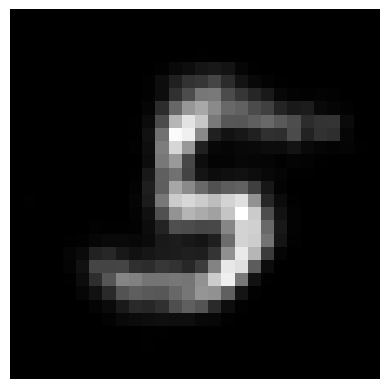

In [12]:
import matplotlib.pyplot as plt

img7 = model.generate_images(5, prior_std=1.0)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()